# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.RandomRotation((-6.0, 6.0), fill=(1,)),
                                       transforms.RandomAffine(degrees=7, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                                     #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 88517343.87it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 92682244.70it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30229176.23it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21550371.91it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
train_loader.multiprocessing_context

# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

# The model
Let's start with the model we first saw

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),

            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout2d(0.06)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),

            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.06)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),


            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.06)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout2d(0.06)
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),


            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.05)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout2d(0.06)
        ) # output_size = 7
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.06)
        ) # output_size = 7
        # OUTPUT BLOCK

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.AvgPool2d(5)
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size =

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
         Dropout2d-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
         Dropout2d-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           2,304
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
        Dropout2d-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14            [-

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Train set: Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [9]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Train set: Loss=0.32067546248435974 Batch_id=468 Accuracy=71.47: 100%|██████████| 469/469 [00:51<00:00,  9.14it/s]



Test set: Average loss: 0.0910, Accuracy: 9763/10000 (97.63%)

EPOCH: 1


Train set: Loss=0.24419909715652466 Batch_id=468 Accuracy=91.13: 100%|██████████| 469/469 [00:46<00:00, 10.10it/s]



Test set: Average loss: 0.0493, Accuracy: 9845/10000 (98.45%)

EPOCH: 2


Train set: Loss=0.2043902426958084 Batch_id=468 Accuracy=92.90: 100%|██████████| 469/469 [00:45<00:00, 10.37it/s]



Test set: Average loss: 0.0389, Accuracy: 9877/10000 (98.77%)

EPOCH: 3


Train set: Loss=0.1708555966615677 Batch_id=468 Accuracy=93.80: 100%|██████████| 469/469 [00:46<00:00, 10.07it/s]



Test set: Average loss: 0.0329, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Train set: Loss=0.1602696031332016 Batch_id=468 Accuracy=94.27: 100%|██████████| 469/469 [00:44<00:00, 10.49it/s]



Test set: Average loss: 0.0345, Accuracy: 9882/10000 (98.82%)

EPOCH: 5


Train set: Loss=0.10919246077537537 Batch_id=468 Accuracy=94.60: 100%|██████████| 469/469 [00:45<00:00, 10.31it/s]



Test set: Average loss: 0.0288, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Train set: Loss=0.1160440742969513 Batch_id=468 Accuracy=95.17: 100%|██████████| 469/469 [00:47<00:00,  9.88it/s]



Test set: Average loss: 0.0256, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Train set: Loss=0.1481274664402008 Batch_id=468 Accuracy=95.32: 100%|██████████| 469/469 [00:45<00:00, 10.39it/s]



Test set: Average loss: 0.0254, Accuracy: 9929/10000 (99.29%)

EPOCH: 8


Train set: Loss=0.10771742463111877 Batch_id=468 Accuracy=95.53: 100%|██████████| 469/469 [00:43<00:00, 10.73it/s]



Test set: Average loss: 0.0249, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Train set: Loss=0.17965151369571686 Batch_id=468 Accuracy=95.57: 100%|██████████| 469/469 [00:44<00:00, 10.54it/s]



Test set: Average loss: 0.0248, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Train set: Loss=0.11820133775472641 Batch_id=468 Accuracy=95.48: 100%|██████████| 469/469 [00:43<00:00, 10.70it/s]



Test set: Average loss: 0.0236, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Train set: Loss=0.11872228980064392 Batch_id=468 Accuracy=95.52: 100%|██████████| 469/469 [00:45<00:00, 10.31it/s]



Test set: Average loss: 0.0241, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Train set: Loss=0.07820490002632141 Batch_id=468 Accuracy=95.61: 100%|██████████| 469/469 [00:43<00:00, 10.74it/s]



Test set: Average loss: 0.0240, Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Train set: Loss=0.11071968823671341 Batch_id=468 Accuracy=95.61: 100%|██████████| 469/469 [00:43<00:00, 10.79it/s]



Test set: Average loss: 0.0241, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Train set: Loss=0.054052140563726425 Batch_id=468 Accuracy=95.56: 100%|██████████| 469/469 [00:44<00:00, 10.51it/s]



Test set: Average loss: 0.0239, Accuracy: 9938/10000 (99.38%)

EPOCH: 15


Train set: Loss=0.07309611886739731 Batch_id=468 Accuracy=95.60: 100%|██████████| 469/469 [00:43<00:00, 10.73it/s]



Test set: Average loss: 0.0239, Accuracy: 9935/10000 (99.35%)

EPOCH: 16


Train set: Loss=0.31665316224098206 Batch_id=468 Accuracy=95.62: 100%|██████████| 469/469 [00:45<00:00, 10.36it/s]



Test set: Average loss: 0.0237, Accuracy: 9937/10000 (99.37%)

EPOCH: 17


Train set: Loss=0.12311596423387527 Batch_id=468 Accuracy=95.59: 100%|██████████| 469/469 [00:44<00:00, 10.63it/s]



Test set: Average loss: 0.0237, Accuracy: 9931/10000 (99.31%)

EPOCH: 18


Train set: Loss=0.206093430519104 Batch_id=468 Accuracy=95.71: 100%|██████████| 469/469 [00:43<00:00, 10.78it/s]



Test set: Average loss: 0.0236, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Train set: Loss=0.1116345003247261 Batch_id=468 Accuracy=95.61: 100%|██████████| 469/469 [00:44<00:00, 10.53it/s]



Test set: Average loss: 0.0237, Accuracy: 9934/10000 (99.34%)



In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Train set: Loss=0.3834225833415985 Batch_id=468 Accuracy=73.03: 100%|██████████| 469/469 [00:51<00:00,  9.07it/s]



Test set: Average loss: 0.0962, Accuracy: 9740/10000 (97.40%)

EPOCH: 1


Train set: Loss=0.3912459909915924 Batch_id=468 Accuracy=90.25: 100%|██████████| 469/469 [00:44<00:00, 10.48it/s]



Test set: Average loss: 0.0543, Accuracy: 9838/10000 (98.38%)

EPOCH: 2


Train set: Loss=0.21629375219345093 Batch_id=468 Accuracy=92.45: 100%|██████████| 469/469 [00:47<00:00,  9.80it/s]



Test set: Average loss: 0.0399, Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Train set: Loss=0.29309070110321045 Batch_id=468 Accuracy=93.62: 100%|██████████| 469/469 [00:43<00:00, 10.69it/s]



Test set: Average loss: 0.0393, Accuracy: 9871/10000 (98.71%)

EPOCH: 4


Train set: Loss=0.20113855600357056 Batch_id=468 Accuracy=94.06: 100%|██████████| 469/469 [00:44<00:00, 10.45it/s]



Test set: Average loss: 0.0348, Accuracy: 9888/10000 (98.88%)

EPOCH: 5


Train set: Loss=0.1448187679052353 Batch_id=468 Accuracy=94.47: 100%|██████████| 469/469 [00:43<00:00, 10.72it/s]



Test set: Average loss: 0.0336, Accuracy: 9893/10000 (98.93%)

EPOCH: 6


Train set: Loss=0.15812356770038605 Batch_id=468 Accuracy=94.75: 100%|██████████| 469/469 [00:44<00:00, 10.55it/s]



Test set: Average loss: 0.0350, Accuracy: 9879/10000 (98.79%)

EPOCH: 7


Train set: Loss=0.1428726464509964 Batch_id=468 Accuracy=95.13: 100%|██████████| 469/469 [00:46<00:00, 10.15it/s]



Test set: Average loss: 0.0304, Accuracy: 9897/10000 (98.97%)

EPOCH: 8


Train set: Loss=0.20608997344970703 Batch_id=468 Accuracy=95.10: 100%|██████████| 469/469 [00:43<00:00, 10.68it/s]



Test set: Average loss: 0.0271, Accuracy: 9910/10000 (99.10%)

EPOCH: 9


Train set: Loss=0.11331641674041748 Batch_id=468 Accuracy=95.27: 100%|██████████| 469/469 [00:44<00:00, 10.58it/s]



Test set: Average loss: 0.0274, Accuracy: 9912/10000 (99.12%)

EPOCH: 10


Train set: Loss=0.20644044876098633 Batch_id=468 Accuracy=95.39: 100%|██████████| 469/469 [00:44<00:00, 10.62it/s]



Test set: Average loss: 0.0254, Accuracy: 9920/10000 (99.20%)

EPOCH: 11


Train set: Loss=0.09353115409612656 Batch_id=468 Accuracy=95.53: 100%|██████████| 469/469 [00:43<00:00, 10.71it/s]



Test set: Average loss: 0.0253, Accuracy: 9918/10000 (99.18%)

EPOCH: 12


Train set: Loss=0.23127005994319916 Batch_id=468 Accuracy=95.64: 100%|██████████| 469/469 [00:45<00:00, 10.23it/s]



Test set: Average loss: 0.0239, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Train set: Loss=0.1320861428976059 Batch_id=468 Accuracy=95.78: 100%|██████████| 469/469 [00:43<00:00, 10.69it/s]



Test set: Average loss: 0.0244, Accuracy: 9923/10000 (99.23%)

EPOCH: 14


Train set: Loss=0.05390400066971779 Batch_id=468 Accuracy=95.81: 100%|██████████| 469/469 [00:43<00:00, 10.76it/s]



Test set: Average loss: 0.0245, Accuracy: 9920/10000 (99.20%)

EPOCH: 15


Train set: Loss=0.16962432861328125 Batch_id=468 Accuracy=95.71: 100%|██████████| 469/469 [00:44<00:00, 10.49it/s]



Test set: Average loss: 0.0224, Accuracy: 9923/10000 (99.23%)

EPOCH: 16


Train set: Loss=0.20053112506866455 Batch_id=468 Accuracy=95.98: 100%|██████████| 469/469 [00:43<00:00, 10.82it/s]



Test set: Average loss: 0.0243, Accuracy: 9923/10000 (99.23%)

EPOCH: 17


Train set: Loss=0.1359669715166092 Batch_id=468 Accuracy=95.97: 100%|██████████| 469/469 [00:44<00:00, 10.62it/s]



Test set: Average loss: 0.0246, Accuracy: 9918/10000 (99.18%)

EPOCH: 18


Train set: Loss=0.17038331925868988 Batch_id=468 Accuracy=96.04: 100%|██████████| 469/469 [00:45<00:00, 10.42it/s]



Test set: Average loss: 0.0236, Accuracy: 9925/10000 (99.25%)

EPOCH: 19


Train set: Loss=0.15579362213611603 Batch_id=468 Accuracy=96.04: 100%|██████████| 469/469 [00:43<00:00, 10.76it/s]



Test set: Average loss: 0.0261, Accuracy: 9909/10000 (99.09%)



Text(0.5, 1.0, 'Test Accuracy')

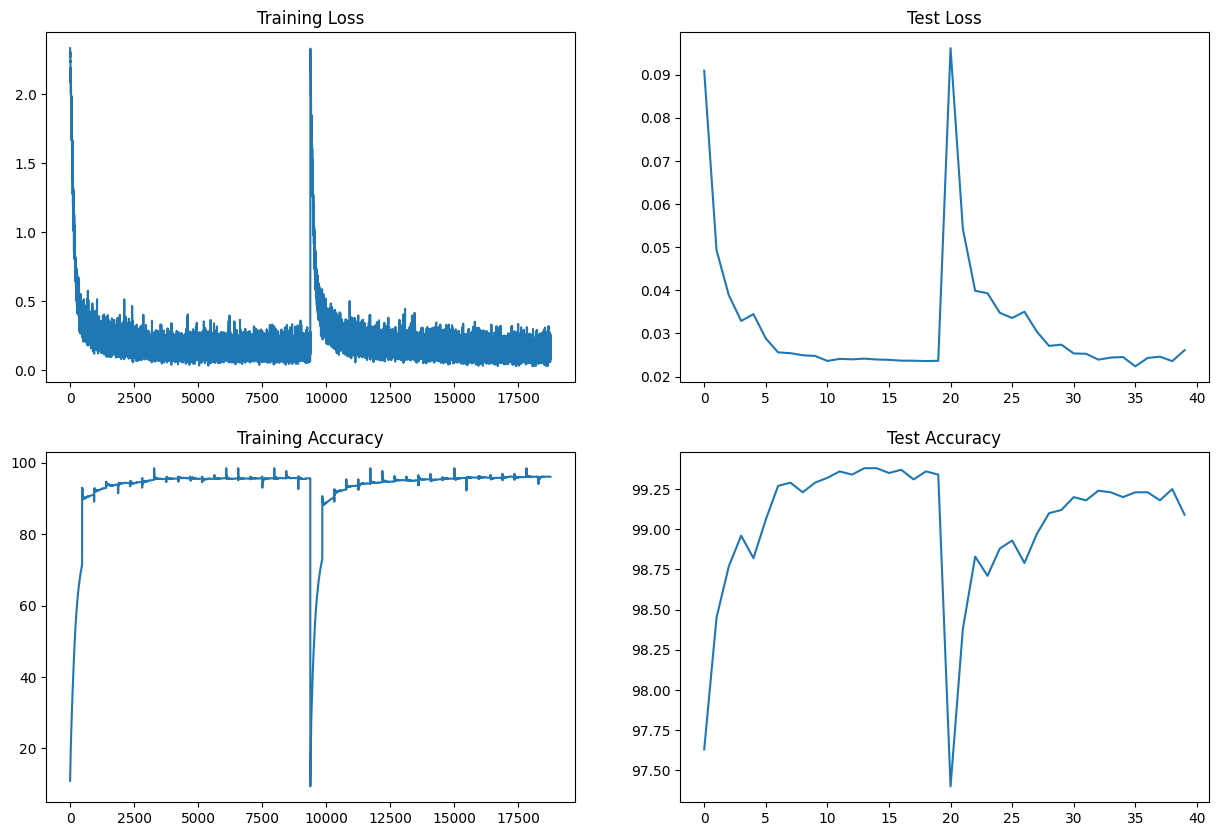

In [11]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")